
=== Momentum Backtest: AAPL (2015-01-01 to 2025-10-28) ===
Total Return                : 397.51%
CAGR                        :  15.99%
Sharpe (ann.)               :   0.88
Max Drawdown                : -25.91%
Exposure (avg position)     :  61.78%
Round-trip entries          : 35
Win rate (entry next-day > 0):  51.43%


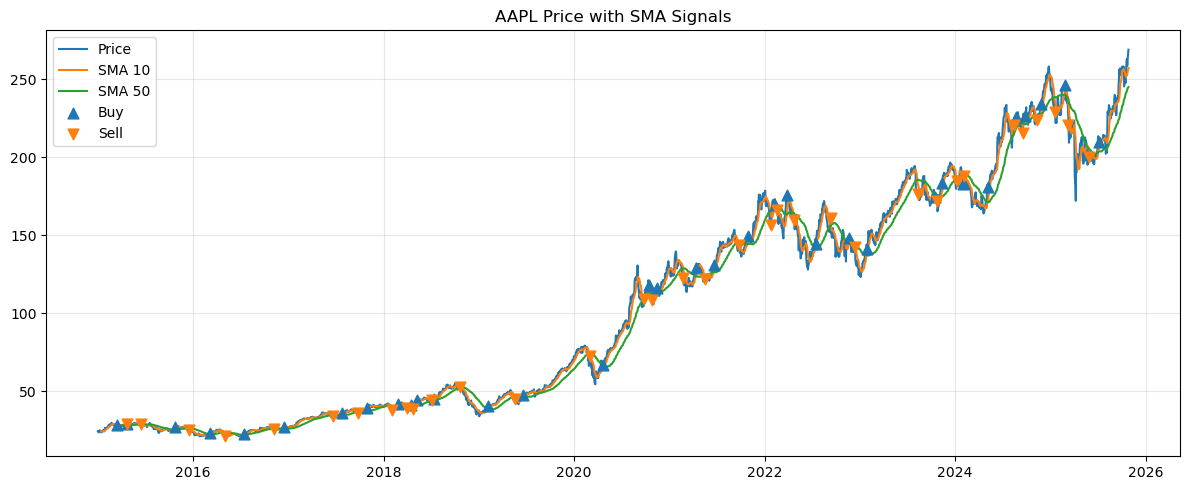

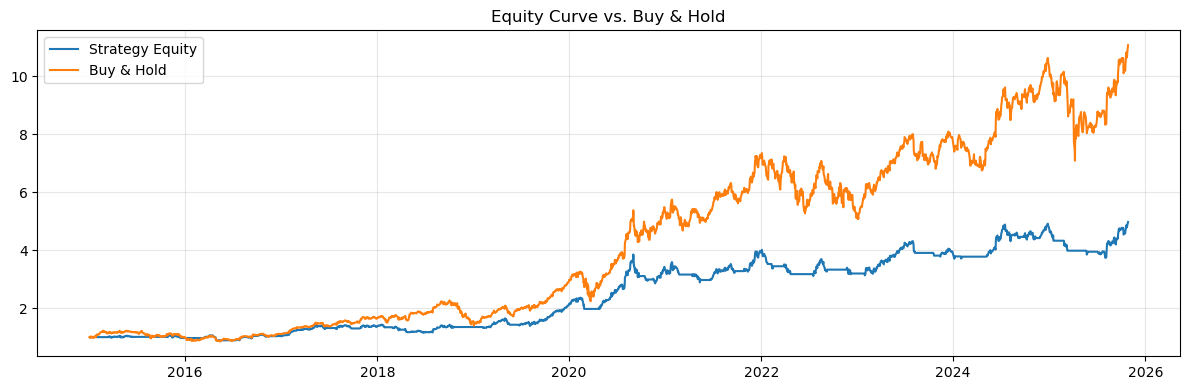

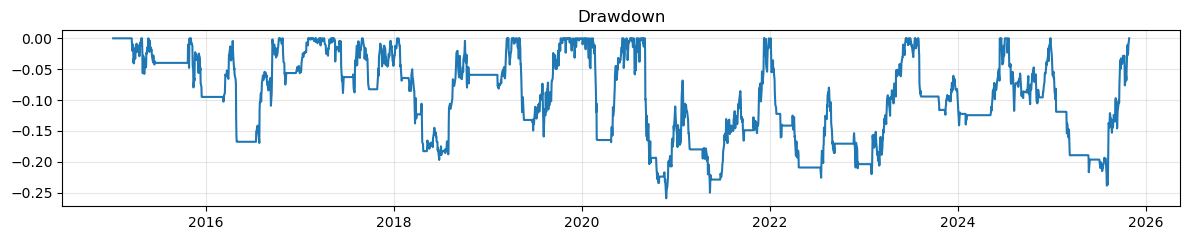

In [3]:

import warnings, sys, math, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


TICKER         = "AAPL"      
START_DATE     = "2015-01-01"
END_DATE       = None        
SHORT_WINDOW   = 10          
LONG_WINDOW    = 50          
COST_BPS       = 5           
RISK_FREE_PCT  = 0.0         
PLOT_SIGNS     = True        


if END_DATE is None:
    END_DATE = dt.date.today().isoformat()

def download_prices(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if data.empty:
        raise ValueError(f"No data returned for {ticker}. Check symbol/dates.")
    data = data[['Close']].rename(columns={'Close':'close'})
    data['ret'] = data['close'].pct_change()
    return data

def compute_signals(df, short_n, long_n):
    df['sma_s'] = df['close'].rolling(short_n).mean()
    df['sma_l'] = df['close'].rolling(long_n).mean()
    df['signal'] = 0
    df.loc[df['sma_s'] > df['sma_l'], 'signal'] = 1   
    df['position'] = df['signal'].shift(1).fillna(0)  
    return df

def apply_costs(df, cost_bps):
    # Trade occurs when position changes; apply round-trip cost as half on entry and half on exit
    df['trade'] = df['position'].diff().fillna(df['position'])
    per_side = (cost_bps / 10000) / 2.0               # convert bps to decimal, split per side
    df['cost'] = 0.0
    df.loc[df['trade'] != 0, 'cost'] = per_side
    # Strategy return: position * asset return minus cost on trade days
    df['strat_ret'] = (df['position'] * df['ret']) - df['cost']
    return df

def performance_metrics(df, rf_annual_pct=0.0):
    daily = df['strat_ret'].dropna()
    if daily.empty:
        raise ValueError("Not enough data to compute metrics.")
    equity = (1 + daily).cumprod()
    total_return = equity.iloc[-1] - 1

    # CAGR
    n_days = (df.index[-1] - df.index[0]).days
    years  = max(n_days / 365.25, 1e-9)
    cagr   = (1 + total_return)**(1/years) - 1

    # Sharpe (daily -> annualized)
    rf_daily = rf_annual_pct/100/252
    excess   = daily - rf_daily
    sharpe   = np.sqrt(252) * (excess.mean() / (excess.std() + 1e-12))

    # Max Drawdown
    roll_max = equity.cummax()
    drawdown = equity/roll_max - 1.0
    max_dd   = drawdown.min()

    # Exposure & trade stats
    exposure = df['position'].mean()                    # fraction of days invested
    trades   = df['trade'].abs().sum()                  # entries+exits counted (since we split costs)
    # Define "round-trip" trades roughly as number of entries (trade==1)
    entries  = (df['trade'] > 0).sum()
    # Win rate: trades where next-period return after entry positive (rough approximation)
    next_r   = df['ret'].shift(-1)
    wins     = next_r[df['trade'] > 0].gt(0).sum()
    winrate  = wins / max(entries, 1)

    return {
        "Total Return": total_return,
        "CAGR": cagr,
        "Sharpe (ann.)": sharpe,
        "Max Drawdown": max_dd,
        "Exposure (avg position)": exposure,
        "Round-trip entries": int(entries),
        "Win rate (entry next-day > 0)": winrate
    }, equity, drawdown

def print_metrics(metrics, ticker):
    print(f"\n=== Momentum Backtest: {ticker} ({START_DATE} to {END_DATE}) ===")
    for k, v in metrics.items():
        if "Sharpe" in k:
            print(f"{k:28s}: {v:6.2f}")
        elif "Round-trip" in k:
            print(f"{k:28s}: {v:d}")
        elif "Win rate" in k or "Exposure" in k:
            print(f"{k:28s}: {v*100:6.2f}%")
        else:
            print(f"{k:28s}: {v*100:6.2f}%")

def plot_results(df, equity, drawdown, ticker):
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['close'], label='Price')
    plt.plot(df.index, df['sma_s'], label=f'SMA {SHORT_WINDOW}')
    plt.plot(df.index, df['sma_l'], label=f'SMA {LONG_WINDOW}')
    if PLOT_SIGNS:
        buys  = df.index[(df['trade'] > 0)]
        sells = df.index[(df['trade'] < 0)]
        plt.scatter(buys,  df.loc[buys,  'close'], marker='^', s=60, label='Buy',  zorder=3)
        plt.scatter(sells, df.loc[sells, 'close'], marker='v', s=60, label='Sell', zorder=3)
    plt.title(f"{ticker} Price with SMA Signals")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(equity.index, equity.values, label='Strategy Equity')
    bh_equity = (1 + df['ret'].fillna(0)).cumprod()
    plt.plot(bh_equity.index, bh_equity.values, label='Buy & Hold')
    plt.title("Equity Curve vs. Buy & Hold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,2.5))
    plt.plot(drawdown.index, drawdown.values)
    plt.title("Drawdown")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#  Run 
df = download_prices(TICKER, START_DATE, END_DATE)
df = compute_signals(df, SHORT_WINDOW, LONG_WINDOW)
df = apply_costs(df, COST_BPS)

metrics, equity, dd = performance_metrics(df, rf_annual_pct=RISK_FREE_PCT)
print_metrics(metrics, TICKER)

# Safe export + plots 
EXPORT = True  

if EXPORT:
    cols = ['close','sma_s','sma_l','position','ret','strat_ret']
    results = df.loc[:, cols].copy()
    results.index = pd.to_datetime(results.index)
    results.index.name = 'date'
    results.to_csv(f"{TICKER}_momentum_results.csv")   

    
    summary = pd.Series(metrics, name='value')
    summary.index.name = 'metric'
    summary.to_csv(f"{TICKER}_momentum_summary.csv")

plot_results(df, equity, dd, TICKER)



=== Strategy vs Buy & Hold ===


,Metric,Strategy,Buy & Hold
0,Total Return,397.51,1007.99
1,CAGR,15.99,24.90
2,Sharpe (ann.),0.88,0.91
3,Max Drawdown,-25.91,-38.52


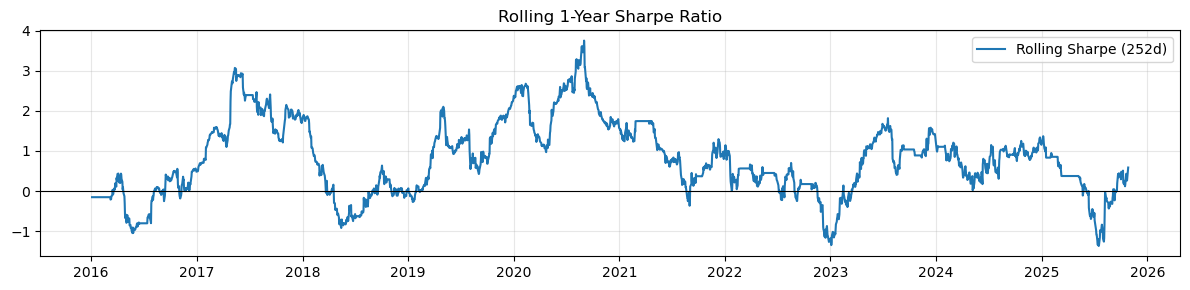


=== Trade-by-Trade Summary ===


,Entry Date,Exit Date,Holding Days,PnL (%)
0,2015-03-17,2015-04-22,26,1.52
1,2015-04-23,2015-06-18,40,-0.66
2,2015-10-23,2015-12-16,38,-3.98
3,2016-03-08,2016-05-02,39,-8.03
4,2016-07-14,2016-11-09,84,15.80
5,2016-12-16,2017-06-20,127,27.36
6,2017-07-26,2017-09-26,44,-1.10
7,2017-10-30,2018-02-02,66,3.22
8,2018-02-27,2018-04-02,24,-6.30
9,2018-04-16,2018-04-25,8,-6.79


In [5]:

df['bh_ret'] = df['ret'].fillna(0)
df['bh_equity'] = (1 + df['bh_ret']).cumprod()
df['strat_equity'] = (1 + df['strat_ret']).cumprod()

perf_comp = pd.DataFrame({
    'Metric': ['Total Return', 'CAGR', 'Sharpe (ann.)', 'Max Drawdown'],
    'Strategy': [
        (df['strat_equity'].iloc[-1]-1)*100,
        ((df['strat_equity'].iloc[-1])**(1/((df.index[-1]-df.index[0]).days/365.25))-1)*100,
        np.sqrt(252)*df['strat_ret'].mean()/df['strat_ret'].std(),
        ((df['strat_equity']/df['strat_equity'].cummax())-1).min()*100
    ],
    'Buy & Hold': [
        (df['bh_equity'].iloc[-1]-1)*100,
        ((df['bh_equity'].iloc[-1])**(1/((df.index[-1]-df.index[0]).days/365.25))-1)*100,
        np.sqrt(252)*df['bh_ret'].mean()/df['bh_ret'].std(),
        ((df['bh_equity']/df['bh_equity'].cummax())-1).min()*100
    ]
})
print("\n=== Strategy vs Buy & Hold ===")
display(perf_comp.round(2))

# 2. Rolling 252-day Sharpe Ratio 
roll_sharpe = np.sqrt(252) * (df['strat_ret'].rolling(252).mean() / df['strat_ret'].rolling(252).std())
plt.figure(figsize=(12,3))
plt.plot(roll_sharpe, label='Rolling Sharpe (252d)')
plt.axhline(0, color='black', lw=0.8)
plt.legend(); plt.title("Rolling 1-Year Sharpe Ratio")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Trade-by-Trade Performance Table ---
trades = df[df['trade'] != 0].copy()
entries = trades[trades['trade'] > 0].index
exits   = trades[trades['trade'] < 0].index

# ensure pairs (same length)
pairs = list(zip(entries, exits[exits > entries[0]])) if len(exits) else []
trade_pnl = []
for ent, ex in pairs:
    sub = df.loc[ent:ex]
    pnl = (sub['strat_ret']+1).prod()-1
    dur = len(sub)
    trade_pnl.append((ent.date(), ex.date(), dur, pnl*100))

trade_df = pd.DataFrame(trade_pnl, columns=['Entry Date','Exit Date','Holding Days','PnL (%)'])
print("\n=== Trade-by-Trade Summary ===")
display(trade_df.head(10).round(2))

# Optional export
trade_df.to_csv(f"{TICKER}_trade_summary.csv", index=False)


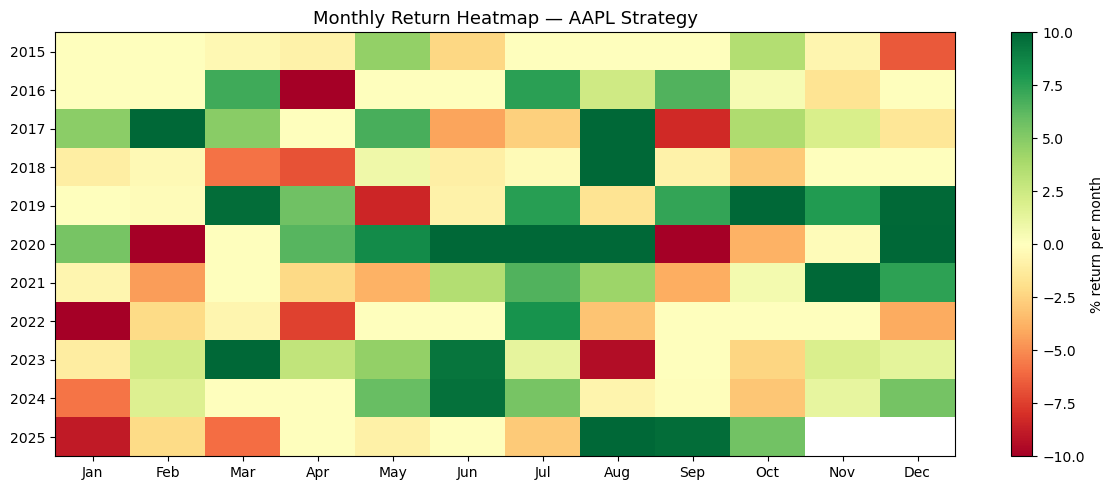

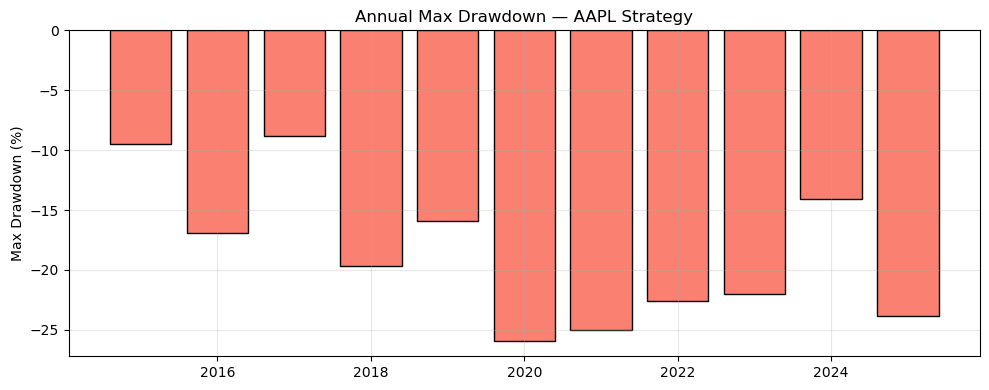

,Max Drawdown (%)
Date,
2015,-9.492370
2016,-16.949592
2017,-8.859700
2018,-19.694477
2019,-15.907243
2020,-25.909894
2021,-24.997200
2022,-22.580089
2023,-21.999727


In [7]:

# 1️⃣ Monthly Return Matrix
monthly_ret = df['strat_ret'].resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_table = monthly_ret.to_frame('Monthly Return')
monthly_table['Year'] = monthly_table.index.year
monthly_table['Month'] = monthly_table.index.month_name().str[:3]
pivot = monthly_table.pivot(index='Year', columns='Month', values='Monthly Return')

# Ensure months are in order
month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
pivot = pivot.reindex(columns=month_order)

# Plot monthly returns heatmap
plt.figure(figsize=(12,5))
plt.title(f"Monthly Return Heatmap — {TICKER} Strategy", fontsize=13)
plt.imshow(pivot*100, cmap='RdYlGn', aspect='auto', vmin=-10, vmax=10)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.colorbar(label='% return per month')
plt.tight_layout()
plt.show()

# 2️⃣ Annual Drawdown Summary
dd = (df['strat_equity']/df['strat_equity'].cummax() - 1)*100
dd_annual = dd.resample('Y').min().to_frame('Max Drawdown (%)')
dd_annual.index = dd_annual.index.year

plt.figure(figsize=(10,4))
plt.bar(dd_annual.index, dd_annual['Max Drawdown (%)'], color='salmon', edgecolor='k')
plt.title(f"Annual Max Drawdown — {TICKER} Strategy")
plt.ylabel('Max Drawdown (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(dd_annual)
